Cередня кількість поїздок для кожного дня тижня за останній місяць

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

# Create SparkSession
spark = SparkSession.builder \
    .appName("SimpleApp") \
    .getOrCreate()



your 131072x1 screen size is bogus. expect trouble
25/04/16 12:14:28 WARN Utils: Your hostname, DESKTOP-DP2FLCF resolves to a loopback address: 127.0.1.1; using 172.22.104.161 instead (on interface eth0)
25/04/16 12:14:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/16 12:14:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df_fare_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_fare_1.csv")
df_trip_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_data_1.csv")

In [3]:
for column in df_fare_init.columns:
    df_fare_init = df_fare_init.withColumnRenamed(column, column.strip().replace(" ", "_"))

In [ ]:
from pyspark.sql.functions import to_date, lit

df_trip = df_trip_init.filter(
    (col("passenger_count") > 0) & (col("passenger_count") <= 10) &
    (col("trip_time_in_secs") > 0) &
    (col("trip_distance") > 0) &
    (col("pickup_latitude").between(40.5, 41.0)) &
    (col("dropoff_latitude").between(40.5, 41.0)) &
    (col("pickup_longitude").between(-74.5, -73.0)) &
    (col("dropoff_longitude").between(-74.5, -73.0)) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

df_fare = df_fare_init.filter(
    (col("fare_amount") >= 0) &
    (col("tip_amount") >= 0) &
    (col("tolls_amount") >= 0) &
    (col("total_amount") >= 0) &
    ((col("fare_amount") > 0) | (col("payment_type") == "NOC")) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

In [33]:
from pyspark.sql.functions import to_date, date_format, count, avg, max as Fmax, date_sub, col, lit

df_last_month = df_trip.withColumn("trip_date", to_date("pickup_datetime")) \
    .withColumn("weekday", date_format("trip_date", "EEEE"))

daily_counts = df_last_month.groupBy("trip_date", "weekday").agg(
    count("*").alias("daily_trip_count")
)

avg_by_weekday = daily_counts.groupBy("weekday").agg(
    avg("daily_trip_count").alias("avg_trip_count")
).orderBy("weekday")

In [34]:
from pyspark.sql.functions import when

ordered = avg_by_weekday.withColumn("weekday_order", 
    when(col("weekday") == "Monday", 1)
    .when(col("weekday") == "Tuesday", 2)
    .when(col("weekday") == "Wednesday", 3)
    .when(col("weekday") == "Thursday", 4)
    .when(col("weekday") == "Friday", 5)
    .when(col("weekday") == "Saturday", 6)
    .when(col("weekday") == "Sunday", 7)
)

ordered.orderBy("weekday_order").drop("weekday_order").show(truncate=False)


+---------+--------------+
|weekday  |avg_trip_count|
+---------+--------------+
|Monday   |411385.75     |
|Tuesday  |453808.0      |
|Wednesday|459330.2      |
|Thursday |488979.4      |
|Friday   |507664.0      |
|Saturday |500409.75     |
|Sunday   |433244.25     |
+---------+--------------+



In [35]:
ordered.coalesce(1).write.mode("overwrite").option("header", True).csv("./results/avg_trips_by_day_of_week.csv")

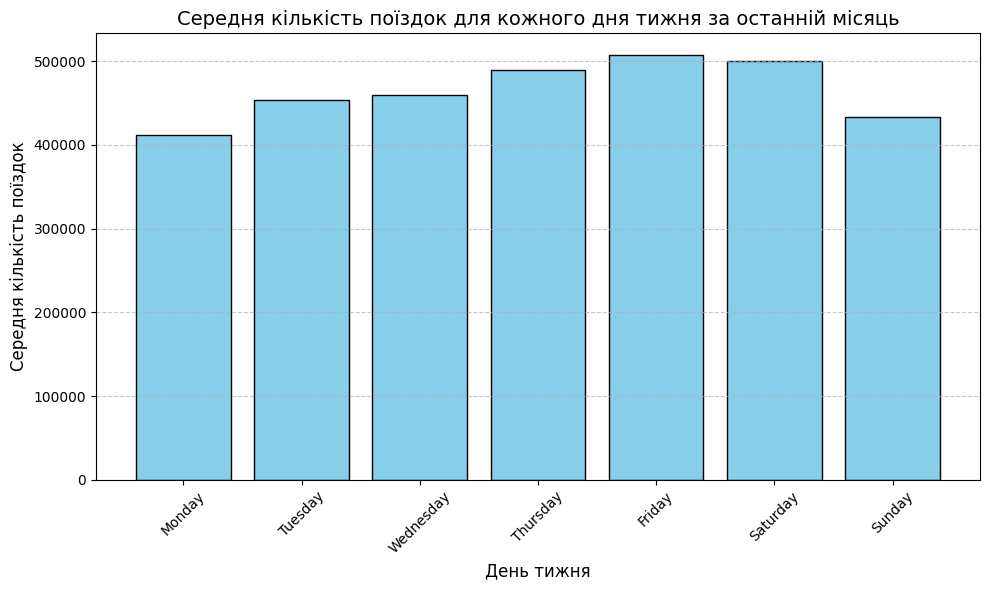

In [36]:
pandas_df = ordered.orderBy("weekday_order").toPandas()
import matplotlib.pyplot as plt

days = pandas_df["weekday"]
avg_trips = pandas_df["avg_trip_count"]

# Побудова графіка
plt.figure(figsize=(10, 6))
plt.bar(days, avg_trips, color='skyblue', edgecolor='black')

# Підпис та стиль
plt.title("Cередня кількість поїздок для кожного дня тижня за останній місяць", fontsize=14)
plt.xlabel("День тижня", fontsize=12)
plt.ylabel("Середня кількість поїздок", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показ графіка
plt.tight_layout()
plt.show()

